# Reproducing Regret Curves

One of the main claims of the paper is that the proposed algorithm enjoys a sublinear regret bound. In this notebook we put this to a test by trying to reproduce the experiment that confirms the aforementioned bound. It does indeed seem that regret is decreasing with increasing of the number of M as proposed in the article. On the other hand, we were unable to reproduce the results using the same parameters as proposed in the article.

In [6]:
%%time

import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.append('../')

from util.TS_DE.TS_DE import TS_DE
from util.TS_DE.BayesRGT import BayesRGT
from util.common import zero_population, linear_bayesian_utility_model

CPU times: total: 0 ns
Wall time: 0 ns


**Reproducing left-hand side Figure 6.1.:**

Visualization shows population-averaged regret with varying population sizes M. Each curve is averaged over 100 trials.

**Parameter setup:**
- *d=10*
- *T=100*
- *mu=0.08*
- *d=10*
- *sigma=1*
- *lambda_=1*

**Claims we are testing:**
(1) TS-DE reaches sublinear regret bound that decreases with the number of sequences in the population.

In [7]:
%%time

np.random.seed(seed=0)

# Initial setting for TS-DE and DE
d = 10
T = 100
mu = 0.8
sigma = 1
lambda_ = 1
f = linear_bayesian_utility_model

# Theta star - optimal theta - parametrization of the linear Bayesian utility model for
# which we aim to optimize the protein design.
theta_star = np.random.multivariate_normal(np.zeros(d), np.eye(d))

# Number of trials to smoothen the regret curves
n_trials = 100

# To make the code a bit more slick, we save all results to this variable
# This will later be used for visualization
results = {
    '10': [],
    '20': [],
    '40': [],
    '90': []

}

CPU times: total: 0 ns
Wall time: 1.07 ms


In [8]:
%%time

for i in tqdm(range(n_trials)):
    for M in [10, 20, 40, 90]:
        S_0 = zero_population(d=d,
                              M=M)

        populations, thetas = TS_DE(d=d,
                                    T=T,
                                    M=M,
                                    S_0=S_0,
                                    mu=mu,
                                    theta_star=theta_star,
                                    sigma=sigma,
                                    lambda_=lambda_,
                                    f=f)

        regret_curve = [BayesRGT(M=M,
                                 T=ix_S + 1,
                                 f=f,
                                 theta_star=theta_star,
                                 thetas=thetas,
                                 populations=populations[:(ix_S + 1)]) for ix_S in range(len(populations))]
        results[str(M)].append(regret_curve)

100%|██████████| 100/100 [16:42<00:00, 10.03s/it]

CPU times: total: 16min 25s
Wall time: 16min 42s


In [9]:
%%time

data = []
for M in results.keys():
    results_M = np.array(results[M]).T
    for T in range(len(results_M)):
        results_M_T = results_M[T]
        data.extend([{
            'M': M,
            'T': T,
            'population regret': regret_i
        } for regret_i in results_M[T]])
df = pd.DataFrame(data)

CPU times: total: 109 ms
Wall time: 117 ms


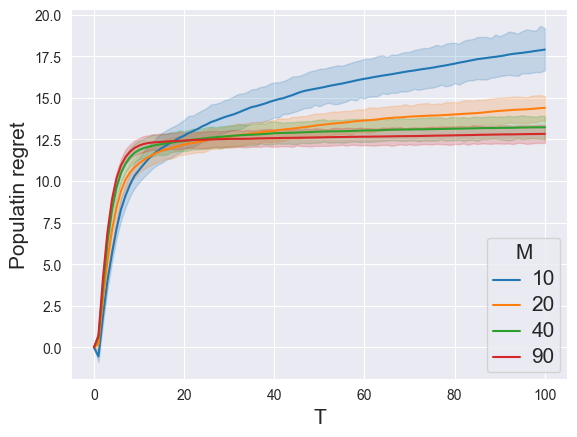

CPU times: total: 14.8 s
Wall time: 14.9 s


In [10]:
%%time

ax = sns.lineplot(data=df,
                  x='T',
                  y='population regret',
                  hue='M',
                  errorbar=('ci', 95))
ax.set_xlabel('T', fontsize='15')
ax.set_ylabel('Populatin regret', fontsize='15')

plt.setp(ax.get_legend().get_texts(), fontsize='15')
plt.setp(ax.get_legend().get_title(), fontsize='15')

plt.savefig('../plots/regret_curves.png')
plt.show()